# Know Your Consumer: Predictive Modeling for Online Shopping Outcomes

Halladay Kinsey, Vivian Perng, Daniel Grant

# Exploratory Data Analysis

### Thoughts after first look:


*  No missing vals - too simple? (add models)
*  High class imbalance
*  Oversampling method for balancing dataset (paper)

### Model Thoughts


*   RF
*   SVM
*   MLP
*   XGBoost
*   Simple DT?
*   Models for relationships between specific variables to add some complexity to the data
*   Sampling models



*  Paper used Gradient Boosting Classification model & oversampling for high accuracy





In [1]:
# Importing necessary libraries
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import RandomizedSearchCV


warnings.filterwarnings('ignore')

In [2]:
# Mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/My Drive/AAI510: Final Project/online_shoppers_intention.csv'

# Loading data
df = pd.read_csv(file_path)

# Checking to ensure proper loading
print(df.shape)
print(df.head())

(12330, 18)
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         

### Missing Value Check

In [4]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing Values in Dataset:\n", missing_values)

Missing Values in Dataset:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


### Overall Revenue Distribution

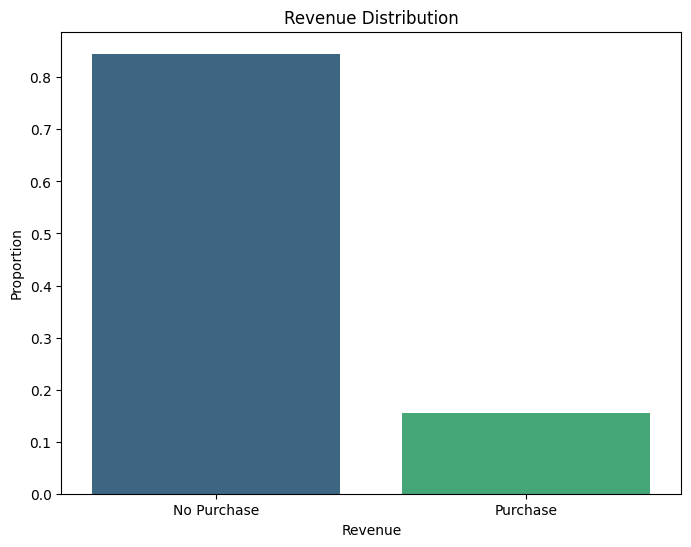

In [5]:
# Plotting distribution of Revenue
revenue_distribution = df['Revenue'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=revenue_distribution.index, y=revenue_distribution.values, palette='viridis')
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No Purchase', 'Purchase'])
plt.show()

## Numerical Columns

### Summary Statistics

In [6]:
# Summary statistics for numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
summary_statistics = df[numerical_columns].describe()
print("Summary Statistics of Numerical Columns:\n", summary_statistics)

Summary Statistics of Numerical Columns:
        Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25

### Multivariate Analysis for All Features

In [7]:
# Multivariate Analysis through pair plot for the entire dataframe
#sns.pairplot(df)

### Correlation

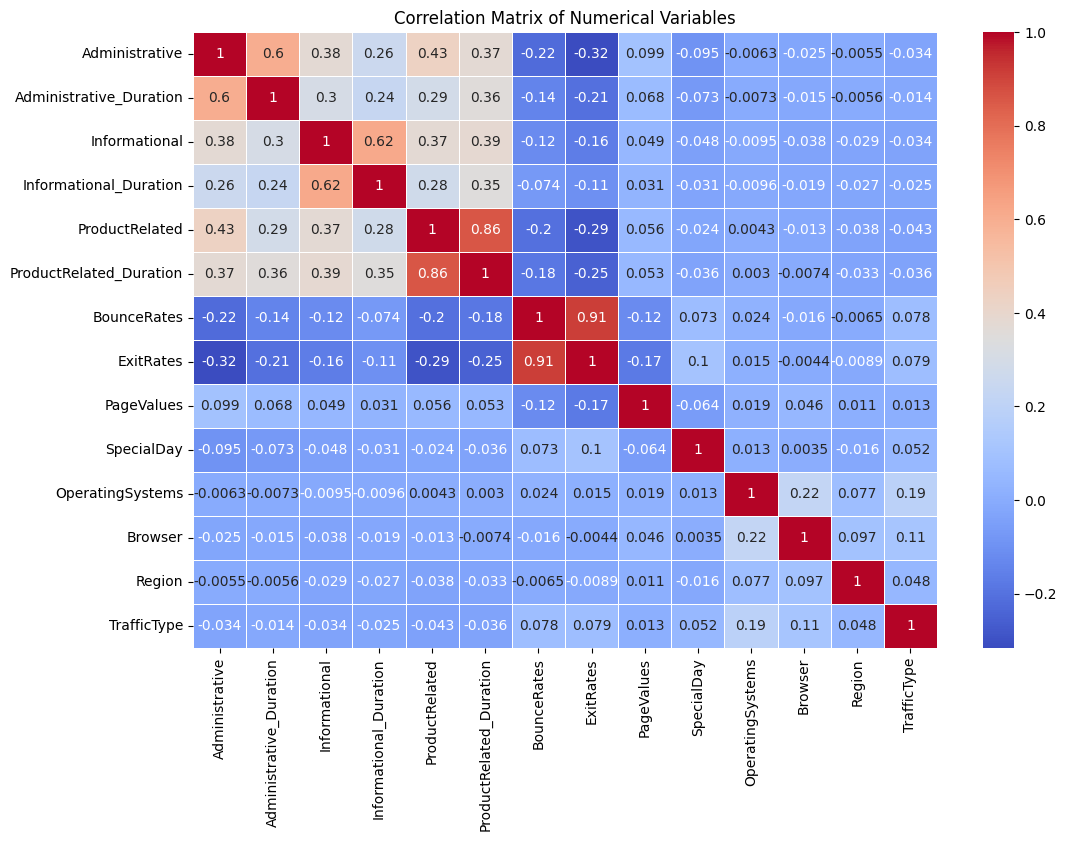

In [8]:
# Correlation matrix & heatmap
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

### Most correlated variables

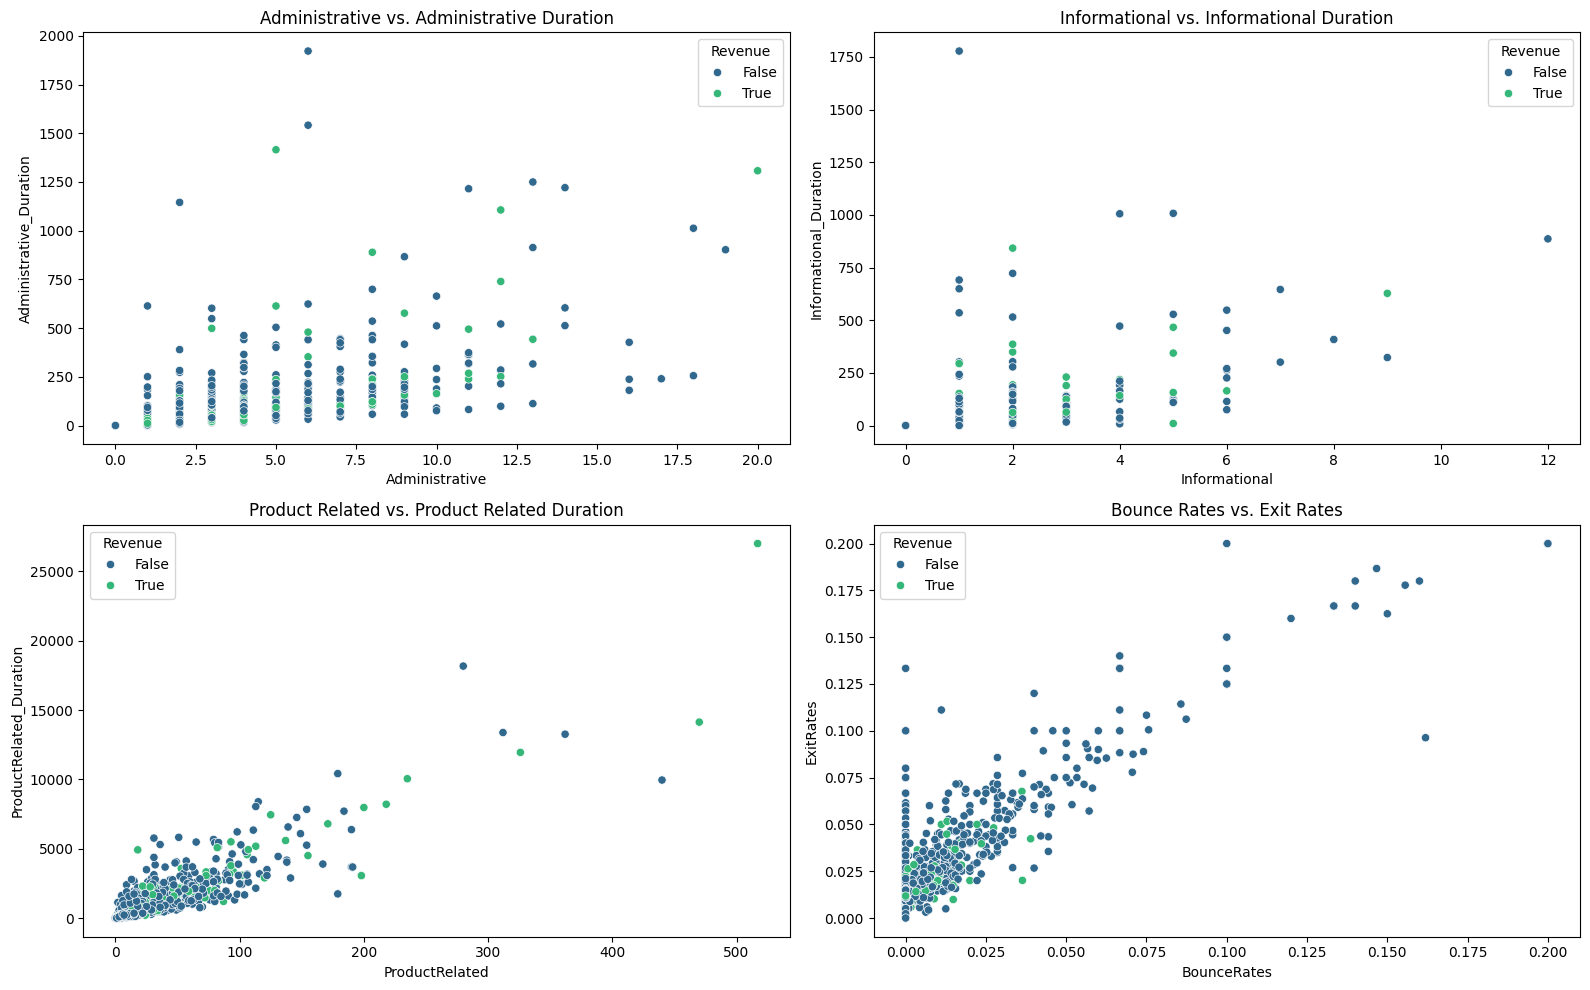

In [9]:
# Sampling data for overfitting
sampled_df = df.sample(1000, random_state=1)

plt.figure(figsize=(16, 10))

# Administrative vs. Administrative Duration
plt.subplot(2, 2, 1)
sns.scatterplot(data=sampled_df, x='Administrative', y='Administrative_Duration', hue='Revenue', palette='viridis')
plt.title('Administrative vs. Administrative Duration')

# Informational vs. Informational Duration
plt.subplot(2, 2, 2)
sns.scatterplot(data=sampled_df, x='Informational', y='Informational_Duration', hue='Revenue', palette='viridis')
plt.title('Informational vs. Informational Duration')

# Product Related vs. Product Related Duration
plt.subplot(2, 2, 3)
sns.scatterplot(data=sampled_df, x='ProductRelated', y='ProductRelated_Duration', hue='Revenue', palette='viridis')
plt.title('Product Related vs. Product Related Duration')

# Bounce Rates vs. Exit Rates
plt.subplot(2, 2, 4)
sns.scatterplot(data=sampled_df, x='BounceRates', y='ExitRates', hue='Revenue', palette='viridis')
plt.title('Bounce Rates vs. Exit Rates')

plt.tight_layout()
plt.show()

### Outlier Check

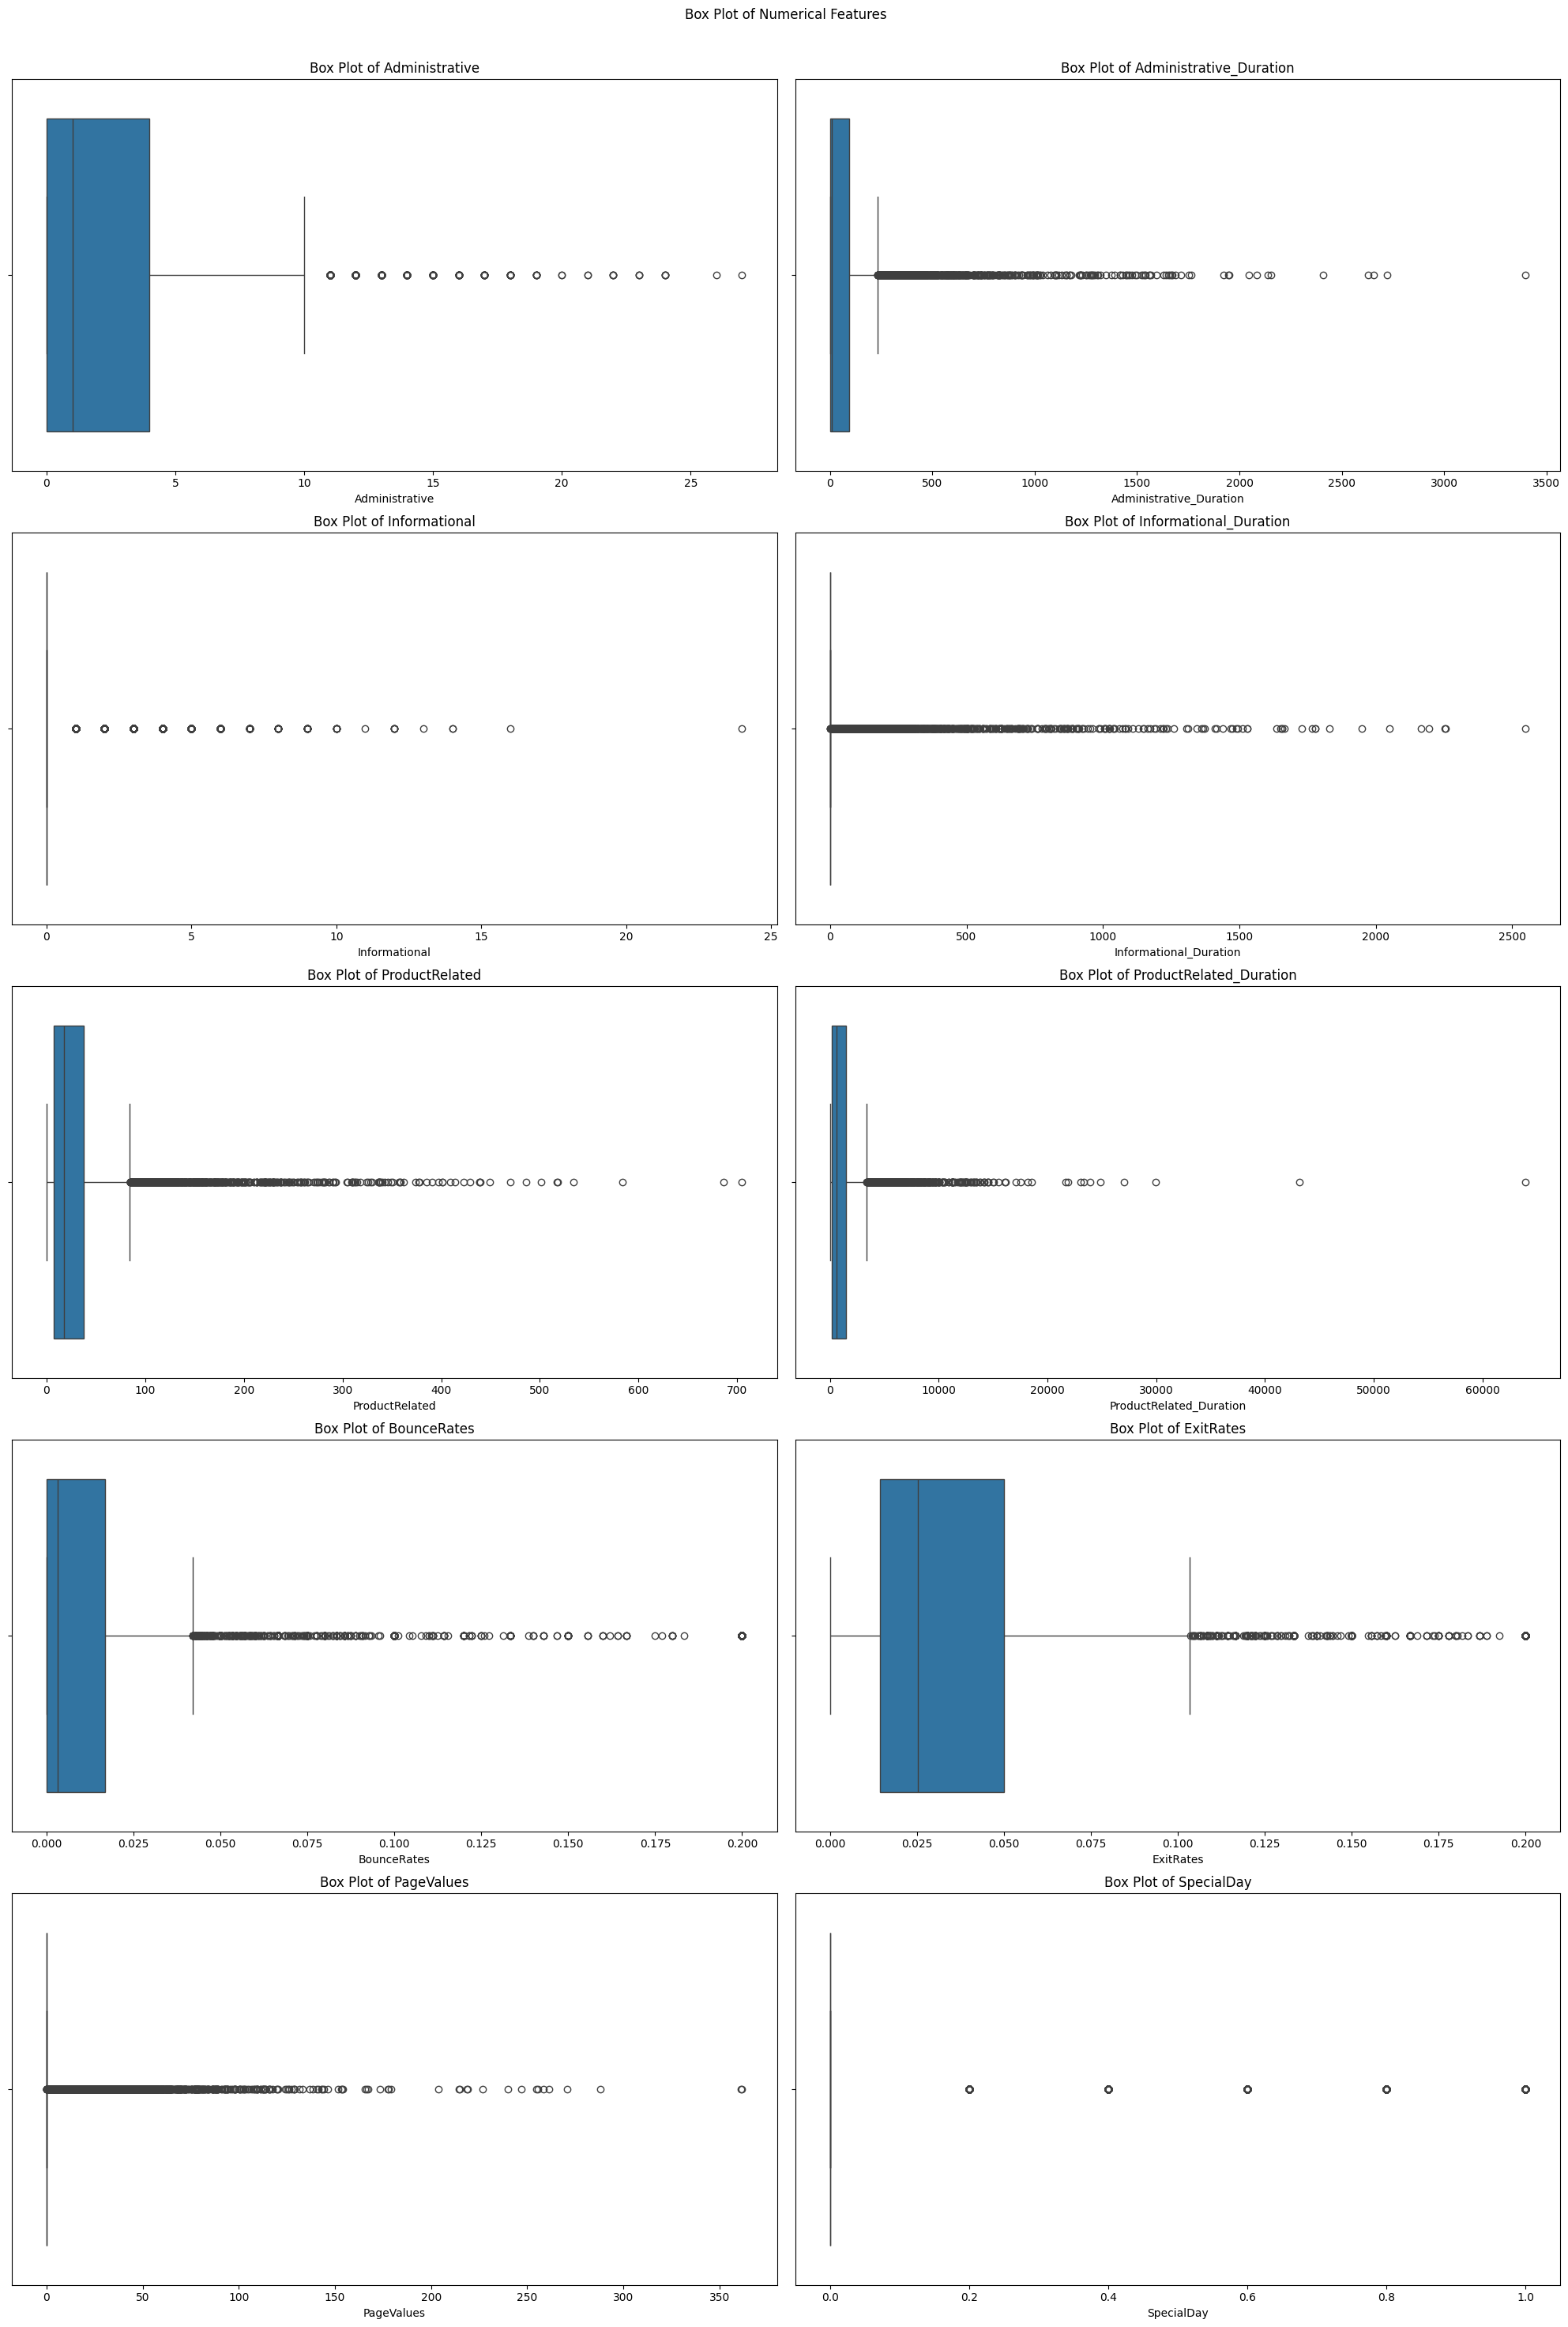

In [10]:
# List of numerical columns to plot
numerical_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                  'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

fig, axes = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle('Box Plot of Numerical Features')

# Iterating over numerical columns
for col, ax in zip(numerical_cols, axes.flatten()):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Distribution of Numerical Variables

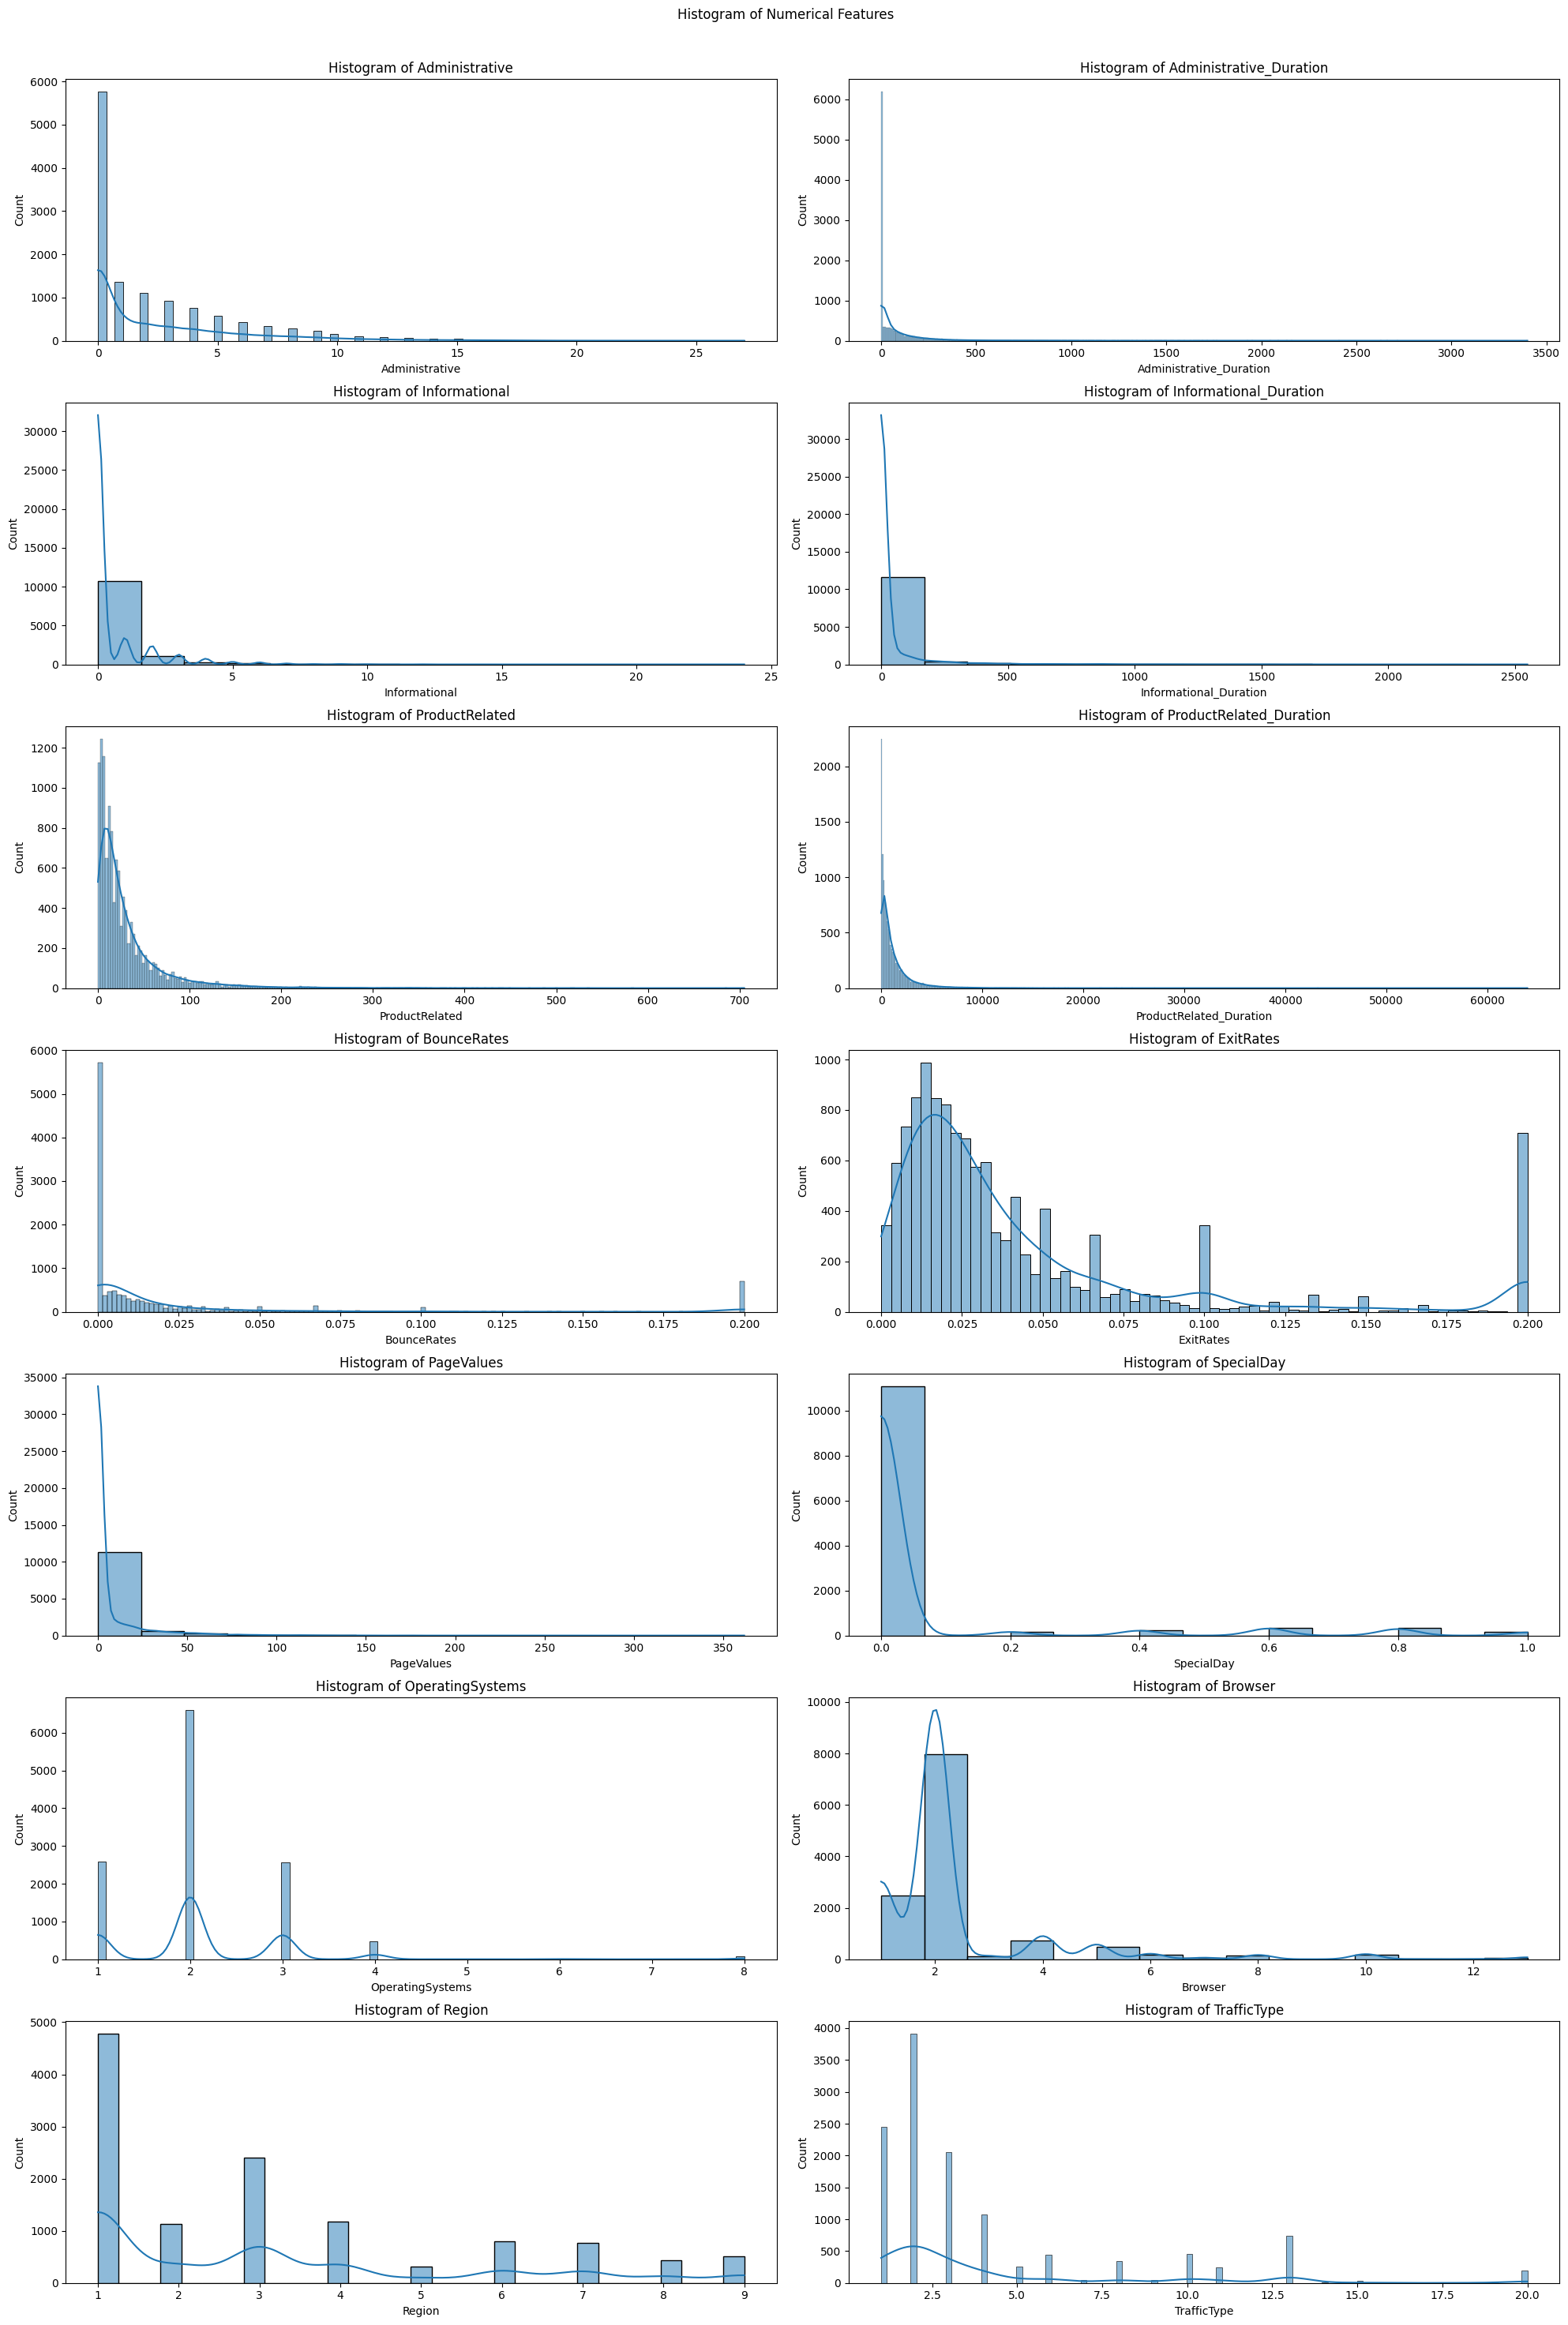

In [11]:
# List of all numerical columns
numerical_list = numerical_columns.tolist()

fig, axes = plt.subplots(7, 2, figsize=(20, 30))
fig.suptitle('Histogram of Numerical Features')

# Iterating over numerical columns
for col, ax in zip(numerical_list, axes.flatten()):
    sns.histplot(data=df, x=col, ax=ax, kde=True)
    ax.set_title(f'Histogram of {col}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Comparison of Distributions of Target Variable for Numerical Columns

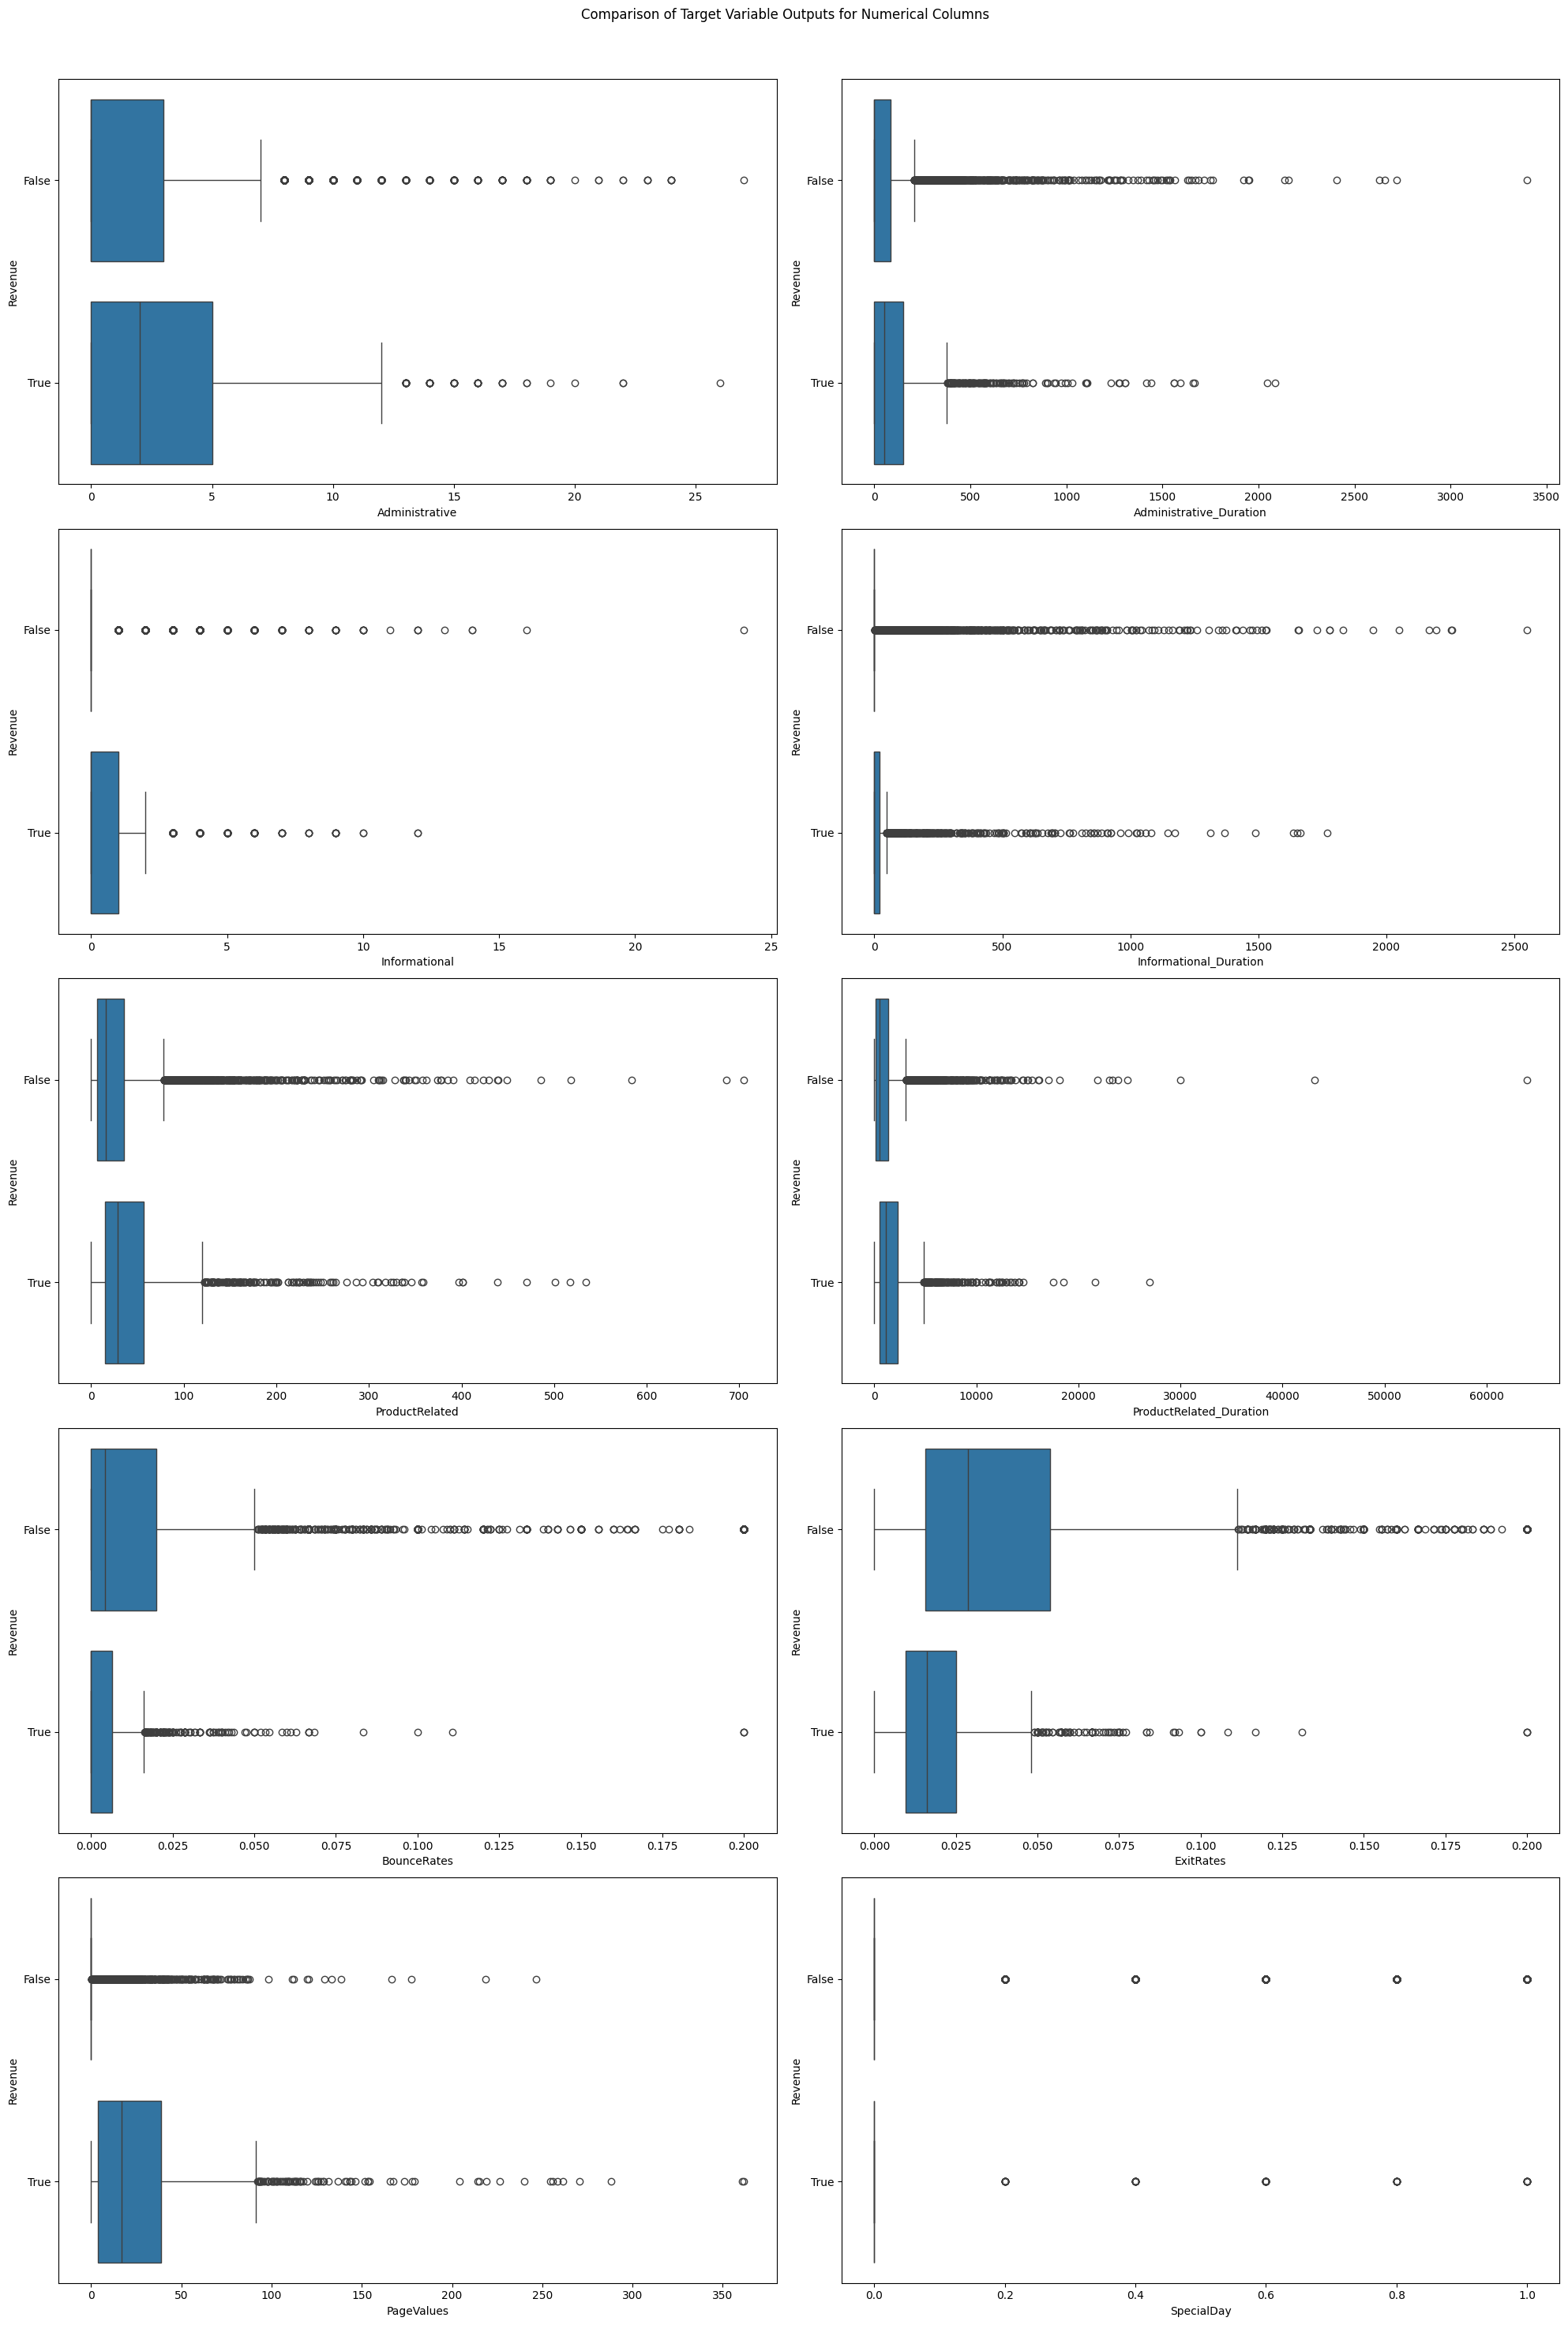

In [12]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle('Comparison of Target Variable Outputs for Numerical Columns')

# Create box plots comparing False Revenue and True Revenue for each feature
for col, ax in zip(numerical_cols, axes.flatten()):
    sns.boxplot(x=col, y='Revenue', data=df, ax=ax, orient='h')
    plt.ylabel('Revenue')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Categorical Columns

### Distribution

In [13]:
# Distribution of categorical variables
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
categorical_distributions = {}
for col in categorical_columns:
    categorical_distributions[col] = df[col].value_counts()
for col, value_counts in categorical_distributions.items():
    print(f"Distribution of {col}:\n{value_counts}\n")
# categorical_distributions = df[categorical_columns].apply(lambda x: x.value_counts())
# print("Distribution of Categorical Variables:\n", categorical_distributions)

Distribution of Month:
Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

Distribution of VisitorType:
VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

Distribution of Weekend:
Weekend
False    9462
True     2868
Name: count, dtype: int64

Distribution of Revenue:
Revenue
False    10422
True      1908
Name: count, dtype: int64



### Distribution by Revenue

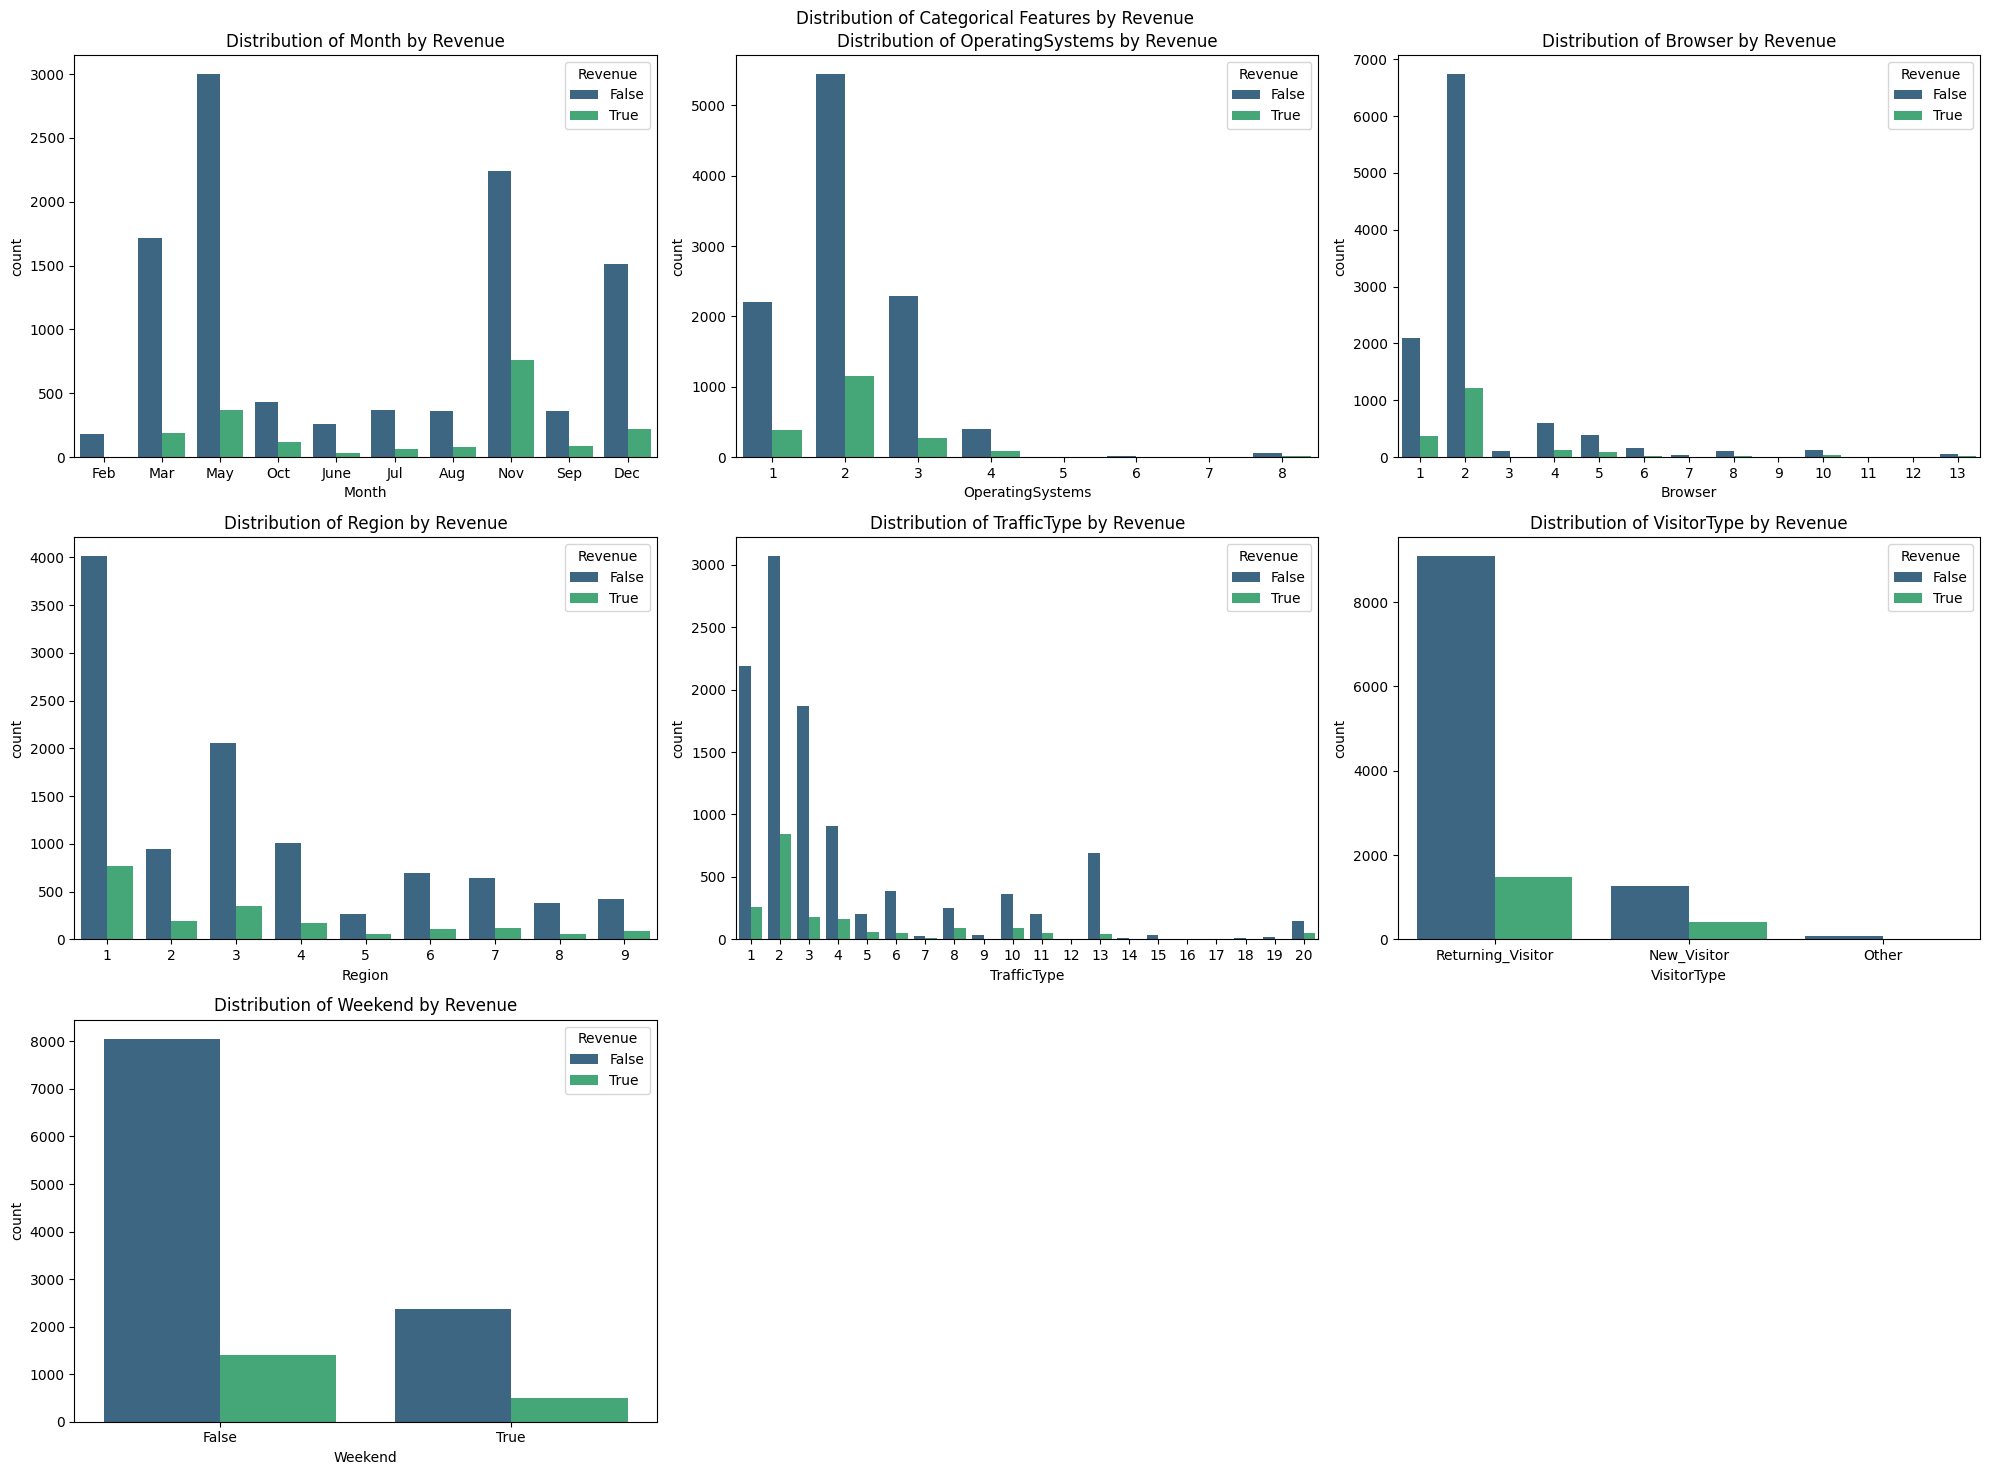

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Distribution of Categorical Features by Revenue')

# Categorical columns
categorical_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

# Iterating over categorical columns
for col, ax in zip(categorical_cols, axes.flatten()):
    sns.countplot(data=df, x=col, hue='Revenue', palette='viridis', ax=ax)
    ax.set_title(f'Distribution of {col} by Revenue')
    ax.legend(title='Revenue', loc='upper right')

# Removing empty subplots
for i in range(len(categorical_cols), 9):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

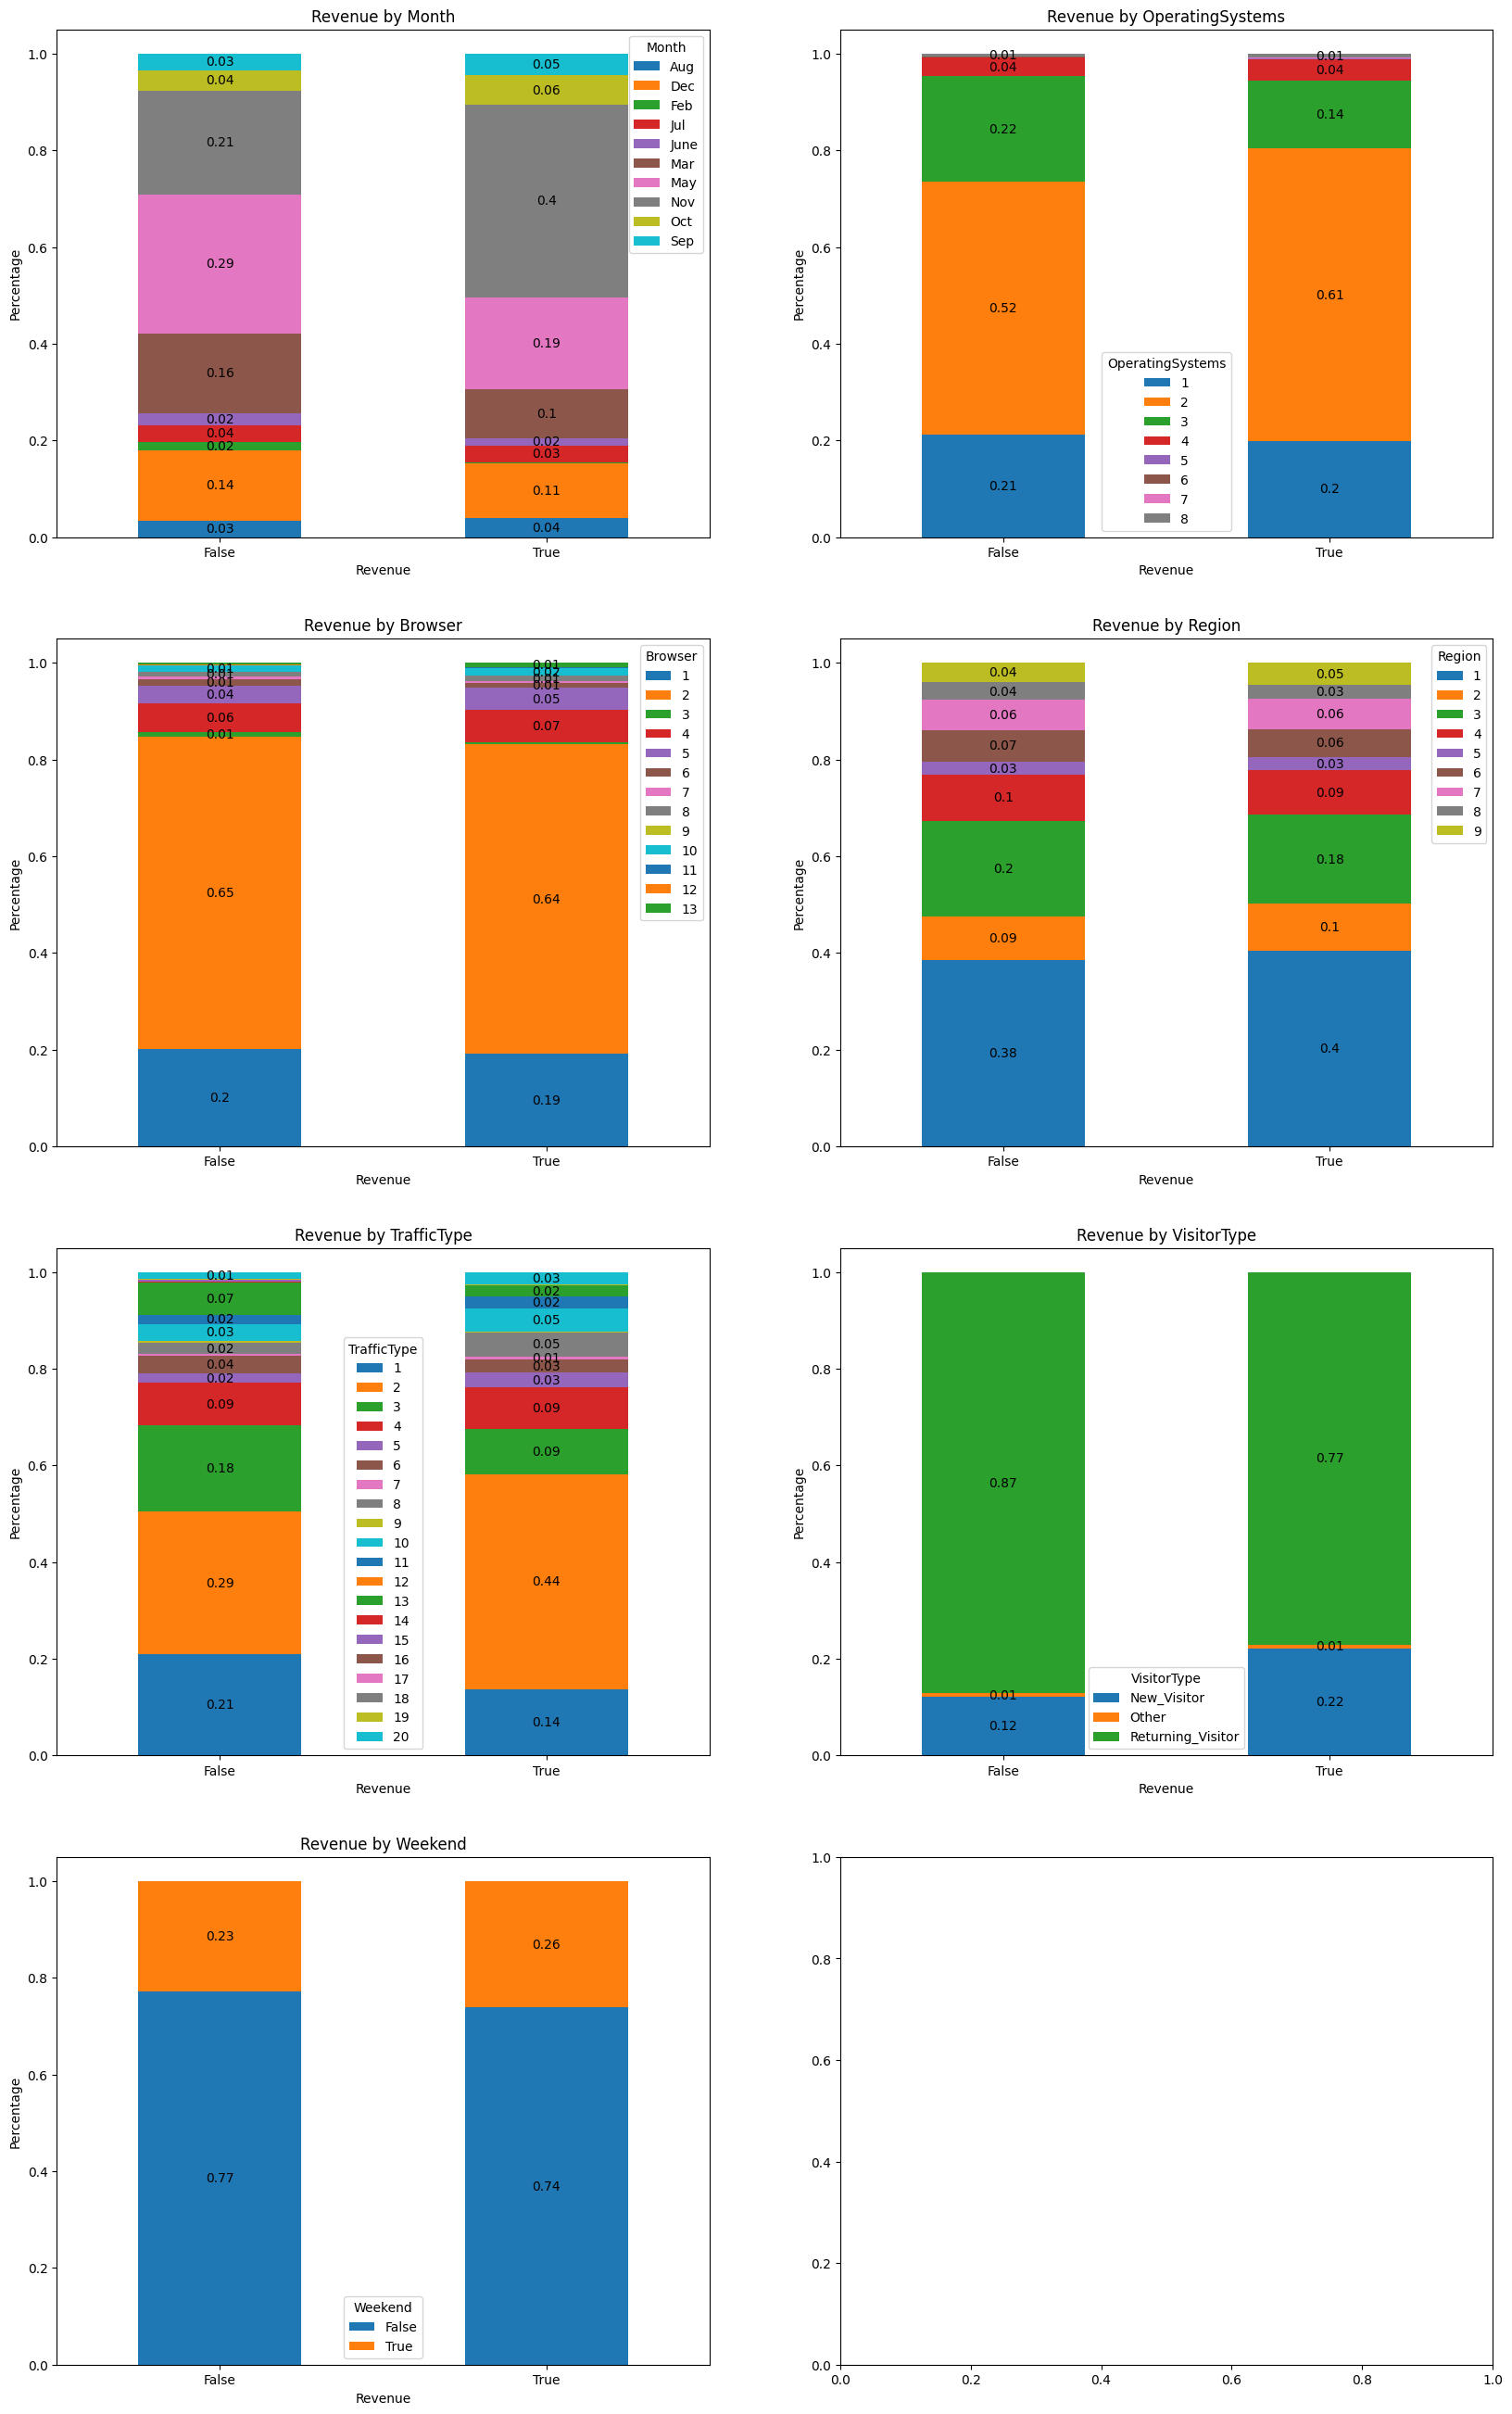

In [15]:
#Prepared data for visualization
def percent_of_total(second_column):
    percent = df.groupby(['Revenue', second_column]).size().unstack().fillna(0)
    for i in range(len(percent)):
        percent.iloc[i,:] = percent.iloc[i,:]/sum(percent.iloc[i,:])
    return percent

# Create box plots comparing False Revenue and True Revenue for each feature
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
for col, ax in zip(categorical_cols, axes.flatten()):
    percentage = percent_of_total(col)
    plot = percentage.plot(ax=ax, kind = 'bar', stacked = True, xlabel = 'Revenue',
                    ylabel = 'Percentage', title = 'Revenue by {}'.format(col), rot =0)
    #label each stack with percentage
    for c in plot.containers:
        labels = [round(v.get_height(),2) if round(v.get_height(),2) > 0 else '' for v in c]
        plot.bar_label(c, labels = labels, label_type = 'center')

plt.subplots_adjust(top=0.95)
plt.show()

### Correlation between Categorical Variables

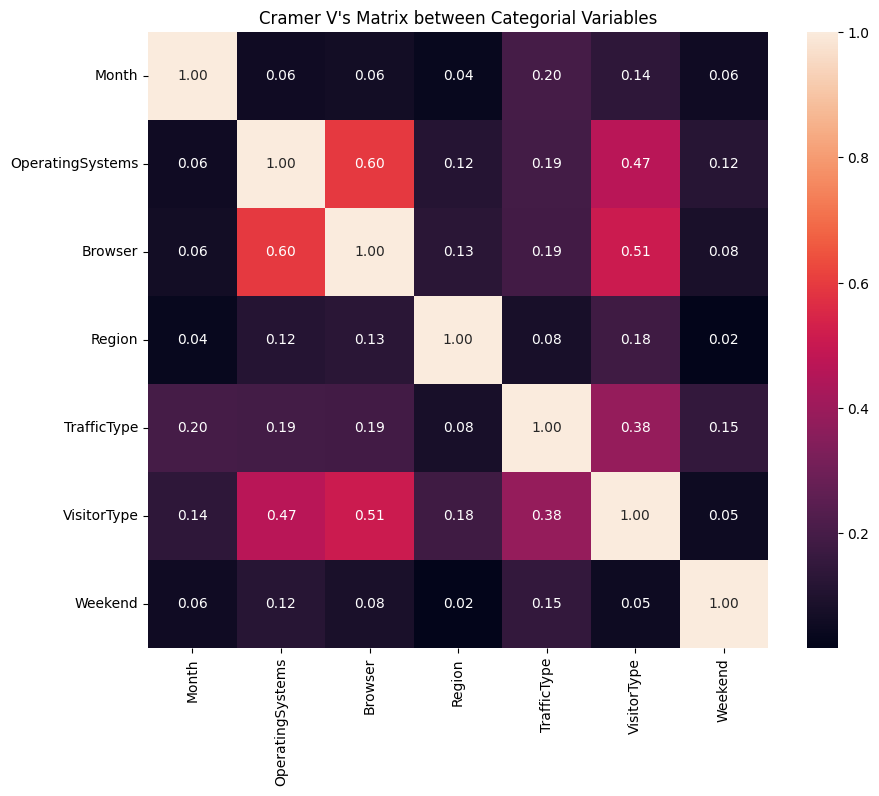

In [16]:
def cramers_v(x,y):
    # Create contingency table
    contingency_table = pd.crosstab(x,y)
    # Calculate chi-square statistic
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    # Cramer's V calculation
    phi2 = chi2/n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min(k_corr-1, r_corr-1))

# Initialize matrix
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                                index=categorical_cols, columns=categorical_cols)

# Loop over variables to fill in the matrix
for i, var1 in enumerate(categorical_cols):
    for j, var2 in enumerate(categorical_cols):
        if i >= j:
           # Cramer's V is symmetric, considering the same pair only once
            if i == j: # Diagonal elements are maximum
                cramers_v_matrix.loc[var1, var2] = 1.0
            else:
                cramers_v_val = cramers_v(df[var1], df[var2])
                cramers_v_matrix.loc[var1, var2] = cramers_v_val
                cramers_v_matrix.loc[var2, var1] = cramers_v_val

# Create a heatmap of the Cramer's V matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f")
plt.title("Cramer V's Matrix between Categorial Variables")
plt.show()

New Features

In [17]:
# seasons and quarters
season_mapping = {
    'Jan': 'Winter', 'Feb': 'Winter', 'Mar': 'Spring',
    'Apr': 'Spring', 'May': 'Spring', 'Jun': 'Summer',
    'Jul': 'Summer', 'Aug': 'Summer', 'Sep': 'Fall',
    'Oct': 'Fall', 'Nov': 'Fall', 'Dec': 'Winter'
}
df['Season'] = df['Month'].map(season_mapping)

quarter_mapping = {
    'Jan': 'Q1', 'Feb': 'Q1', 'Mar': 'Q1',
    'Apr': 'Q2', 'May': 'Q2', 'Jun': 'Q2',
    'Jul': 'Q3', 'Aug': 'Q3', 'Sep': 'Q3',
    'Oct': 'Q4', 'Nov': 'Q4', 'Dec': 'Q4'
}
df['Quarter'] = df['Month'].map(quarter_mapping)

df['IsHolidayMonth'] = df['Month'].apply(lambda x: 1 if x in ['Nov', 'Dec'] else 0) # thanksgiving and christmas months only

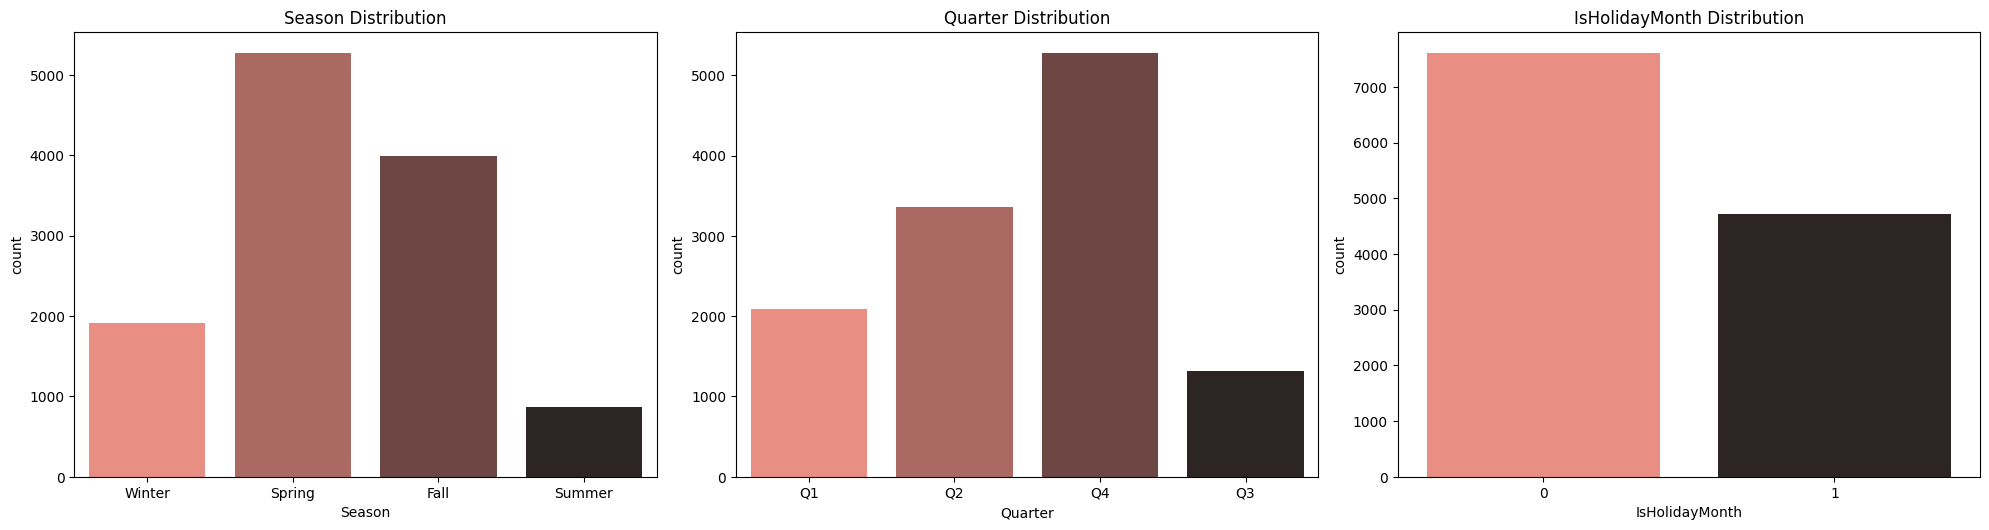

In [18]:
# distribution plots
plt.figure(figsize=(20, 10))

# seasons
plt.subplot(2, 3, 1)
sns.countplot(data=df, x='Season', palette='dark:salmon_r')
plt.title('Season Distribution')

# quarters
plt.subplot(2, 3, 2)
sns.countplot(data=df, x='Quarter', palette='dark:salmon_r')
plt.title('Quarter Distribution')

# IsHolidayMonth
plt.subplot(2, 3, 3)
sns.countplot(data=df, x='IsHolidayMonth', palette='dark:salmon_r')
plt.title('IsHolidayMonth Distribution')

plt.tight_layout()
plt.show()

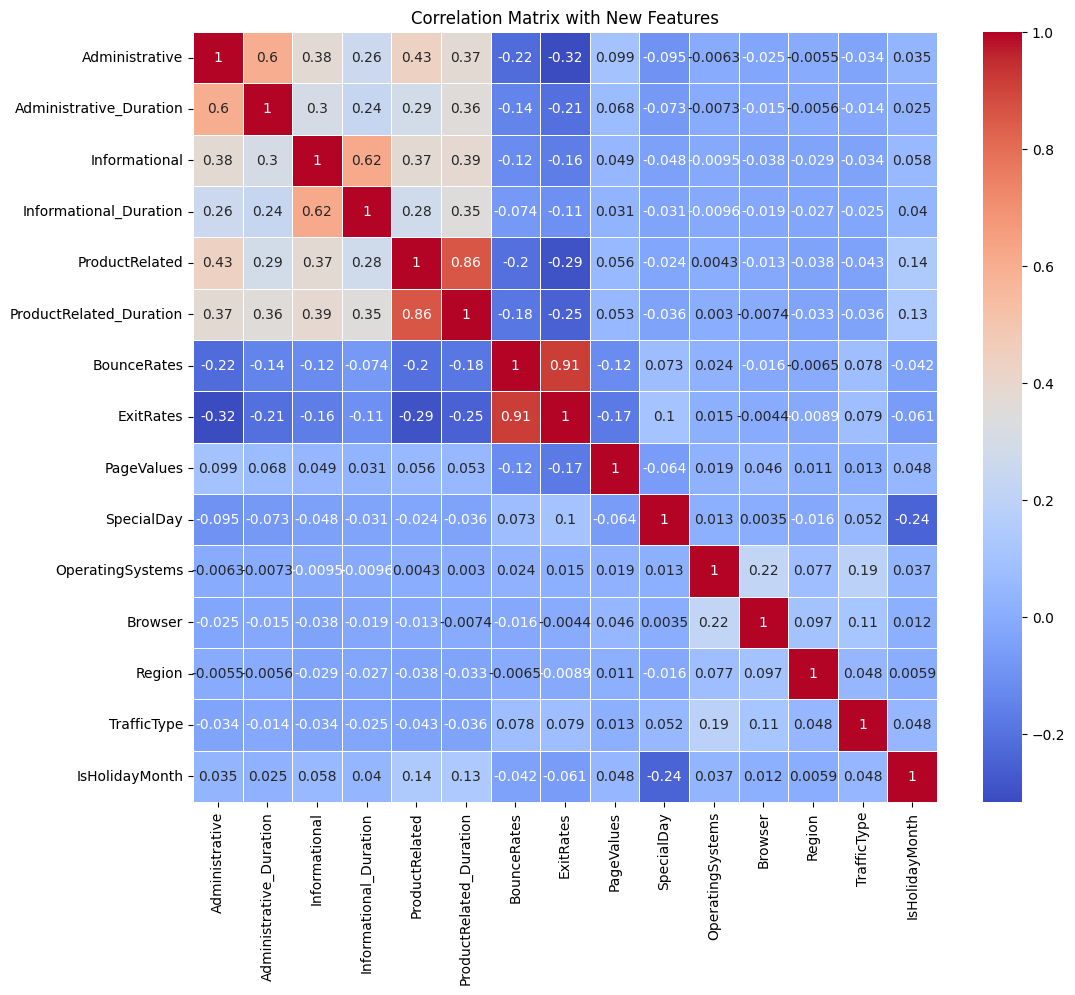

In [19]:
# correlation w/ new features
numerical_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 10))
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix with New Features')
plt.show()

## Findings from Visualizations

### Correlation Matrix with New Features
- **BounceRates** and **ExitRates** are highly correlated (0.91).
- **ProductRelated** and **ProductRelated_Duration** also show a strong correlation (0.86).
- Most other features have low to moderate correlations.

### Season, Quarter, and IsHolidayMonth Distributions
- Spring has the highest count, followed by Fall, Winter, and Summer.
- Q4 and Q2 have the highest counts

### Distribution of Categorical Features by Revenue
- **Month**: May and November have the highest number of purchases.
- **Operating Systems**: Most purchases are from users using Operating System 1, followed by OS 2 and OS 3.
- **Browser**: Browser 2 has the highest number of purchases, followed by Browser 1.
- **Region**: Region 1 has the highest number of purchases.
- **TrafficType**: Traffic type 2 has the highest number of purchases.
- **VisitorType**: Returning visitors have a significantly higher number of purchases compared to new visitors.

### Histogram of Numerical Features
- Most features, like **Administrative, Informational, ProductRelated**, show a right-skewed distribution.
- **BounceRates** and **ExitRates** are concentrated at the lower end with a few high values.
- **PageValues** is also right-skewed with most values near zero.

### Box Plots of Numerical Features
- Many features exhibit significant outliers, particularly in duration-related features (e.g., **Administrative_Duration**, **Informational_Duration**, **ProductRelated_Duration**).

### Scatter Plots
- **BounceRates vs. ExitRates** shows a strong positive correlation.
- **ProductRelated vs. ProductRelated_Duration** shows a positive correlation with a cluster of higher values.
- **Administrative vs. Administrative_Duration** and **Informational vs. Informational_Duration** show less clear patterns with some outliers.

### Key Insights
1. **BounceRates and ExitRates** are highly correlated, suggesting they might be capturing similar behavior of users leaving the site.
2. **Product-related activities** (pages viewed and time spent) are strongly correlated, which is intuitive as more product pages viewed generally mean more time spent.
3. There is a significant class imbalance with most observations not leading to purchases.
4. Certain periods (May, November) and user types (returning visitors) are associated with higher purchase rates.
5. Significant outliers in duration-related features suggest variability in user engagement.

#### Balancing Data


- Since there was a significant imbalance between purchases made and not made, let's apply SMOTE to ensure equal class representation.
- First, we need to encode our categorical variables using one-hot encoding for multiclass variables and the LabelEncoder for binary variables.

In [20]:
# Initialize LabelEncoder
le = LabelEncoder()

# Convert binary categorical variables using LabelEncoder
df['Weekend'] = le.fit_transform(df['Weekend'])
df['Revenue'] = le.fit_transform(df['Revenue'])

# Convert nominal categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=['Month', 'VisitorType', 'Season', 'Quarter'], drop_first=True)

# Check the DataFrame to ensure proper encoding
print(df.head())

   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay  ...  Month_Oct  Month_Sep  \
0         0.20       0.20         0.0         0.0  ...      False      False   
1         0.00       0.10         0.0         0.0  .

In [21]:
# Separate features and target
X = df.drop(columns=['Revenue'])
y = df['Revenue']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verify the new class distribution
print(y_resampled.value_counts())

# Concatenate the resampled the data
df_resampled = pd.concat([X_resampled, y_resampled.rename('Revenue')], axis=1)

Revenue
0    10422
1    10422
Name: count, dtype: int64


#Basic model performance comparison before feature engineering

In [22]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (14590, 33), (14590,)
Testing set: (6254, 33), (6254,)


In [23]:
# Scaling data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)

# Concatenate scaled data into one data frame
df_scaled = pd.concat([X_scaled, y_resampled])

# Split scaled data into training and test sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=42)

In [24]:
# Function for evaluating models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return accuracy, f1

In [25]:
# Random Forest
print("Random Forest:")
rf_model = RandomForestClassifier(random_state=42)
rf_accuracy, rf_f1 = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

Random Forest:
Accuracy: 0.9378
F1 Score: 0.9383
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3123
           1       0.93      0.95      0.94      3131

    accuracy                           0.94      6254
   macro avg       0.94      0.94      0.94      6254
weighted avg       0.94      0.94      0.94      6254

Confusion Matrix:
[[2905  218]
 [ 171 2960]]


In [26]:
# Support Vector Machine
print("\nSupport Vector Machine:")
svm_model = SVC(random_state=42)
svm_accuracy, svm_f1 = evaluate_model(svm_model, X_train, y_train, X_test, y_test)


Support Vector Machine:
Accuracy: 0.7251
F1 Score: 0.7284
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      3123
           1       0.72      0.74      0.73      3131

    accuracy                           0.73      6254
   macro avg       0.73      0.73      0.73      6254
weighted avg       0.73      0.73      0.73      6254

Confusion Matrix:
[[2230  893]
 [ 826 2305]]


In [27]:
# Support Vector Machine with Scaled Data
print("\nSupport Vector Machine with Scaled Data:")
svm_scaled_accuracy, svm_scaled_f1 = evaluate_model(svm_model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


Support Vector Machine with Scaled Data:
Accuracy: 0.9170
F1 Score: 0.9151
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3123
           1       0.94      0.89      0.92      3131

    accuracy                           0.92      6254
   macro avg       0.92      0.92      0.92      6254
weighted avg       0.92      0.92      0.92      6254

Confusion Matrix:
[[2937  186]
 [ 333 2798]]


In [28]:
# Multi Layer Perceptron
print("\nMulti-Layer Perceptron:")
mlp_model = MLPClassifier(random_state=42)
mlp_accuracy, mlp_f1 = evaluate_model(mlp_model, X_train, y_train, X_test, y_test)


Multi-Layer Perceptron:
Accuracy: 0.8666
F1 Score: 0.8555
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3123
           1       0.94      0.79      0.86      3131

    accuracy                           0.87      6254
   macro avg       0.88      0.87      0.87      6254
weighted avg       0.88      0.87      0.87      6254

Confusion Matrix:
[[2952  171]
 [ 663 2468]]


In [29]:
# XGBoost
print("\nXGBoost:")
xgb_model = XGBClassifier(random_state=42)
xgb_accuracy, xgb_f1 = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)


XGBoost:
Accuracy: 0.9314
F1 Score: 0.9316
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3123
           1       0.93      0.93      0.93      3131

    accuracy                           0.93      6254
   macro avg       0.93      0.93      0.93      6254
weighted avg       0.93      0.93      0.93      6254

Confusion Matrix:
[[2902  221]
 [ 208 2923]]


In [30]:
# K-Nearest Neighbors Algorithm
print('\nK-Nearest Neighbors Algorithm')

# Calculate the optimal number of neighbors based on your training data size
n_neighbors = int(np.sqrt(len(X_train)))

# Run and evaluate KNN model on data
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_accuracy, knn_f1 = evaluate_model(knn_model, X_train, y_train, X_test, y_test)


K-Nearest Neighbors Algorithm
Accuracy: 0.7280
F1 Score: 0.7386
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      3123
           1       0.71      0.77      0.74      3131

    accuracy                           0.73      6254
   macro avg       0.73      0.73      0.73      6254
weighted avg       0.73      0.73      0.73      6254

Confusion Matrix:
[[2150  973]
 [ 728 2403]]


In [31]:
# K-Nearest Neighbors Algorithm with Scaled Data
print('\nK-Nearest Neighbors Algorithm with Scaled Data')
knn_accuracy_scaled, knn_f1_scaled = evaluate_model(knn_model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


K-Nearest Neighbors Algorithm with Scaled Data
Accuracy: 0.8428
F1 Score: 0.8297
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      3123
           1       0.91      0.76      0.83      3131

    accuracy                           0.84      6254
   macro avg       0.85      0.84      0.84      6254
weighted avg       0.85      0.84      0.84      6254

Confusion Matrix:
[[2876  247]
 [ 736 2395]]


In [32]:
# Decision Tree Algorithm
print('\Decision Tree Algorithm')

# Run and evaluate KNN model on data
dt_model = DecisionTreeClassifier()
dt_accuracy, dt_f1 = evaluate_model(dt_model, X_train, y_train, X_test, y_test)

\Decision Tree Algorithm
Accuracy: 0.9081
F1 Score: 0.9091
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3123
           1       0.90      0.92      0.91      3131

    accuracy                           0.91      6254
   macro avg       0.91      0.91      0.91      6254
weighted avg       0.91      0.91      0.91      6254

Confusion Matrix:
[[2803  320]
 [ 255 2876]]


# Additional Feature Generation for Highly Correlated Variables

In [33]:
# a little more feature eng
df['Bounce_Exit_Rate'] = df['BounceRates'] * df['ExitRates']
df['Product_Views_Per_Duration'] = df['ProductRelated'] / (df['ProductRelated_Duration'] + 1)
df['Total_Time_Spent'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
df['Engagement_Intensity'] = (
    df['Administrative'] * 0.1 +
    df['Administrative_Duration'] * 0.1 +
    df['Informational'] * 0.2 +
    df['Informational_Duration'] * 0.2 +
    df['ProductRelated'] * 0.3 +
    df['ProductRelated_Duration'] * 0.3
)

Bounce exit rate: Combines bounce and exit rates to capture overall user disengagement

Product views per duration: Measures user engagement by considering product views relative to the time spent

Total time spent: All durations

Engagement intensity: Combining aspects of user activity with different weights to reflect the overall intensity of engagement. The weights (0.1, 0.2, 0.3) can be adjusted based on the perceived importance of each activity

In [34]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Season_Spring,Season_Summer,Season_Winter,Quarter_Q2,Quarter_Q3,Quarter_Q4,Bounce_Exit_Rate,Product_Views_Per_Duration,Total_Time_Spent,Engagement_Intensity
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,True,False,False,False,0.040,1.000000,0.000000,0.30
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,False,False,True,False,False,False,0.000,0.030769,64.000000,19.80
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,True,False,False,False,0.040,1.000000,0.000000,0.30
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,False,False,True,False,False,False,0.007,0.545455,2.666667,1.40
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,False,False,True,False,False,False,0.001,0.015911,627.500000,191.25


In [35]:
# sampling again
X_resampled, y_resampled = smote.fit_resample(X, y)

In [36]:
# re-split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [37]:
# helper to train all models at once
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

In [38]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return accuracy, f1

In [39]:
for name, model in models.items():
    print(f"\n{name}:")
    evaluate_model(model, X_train, y_train, X_test, y_test)


Random Forest:
Accuracy: 0.9378
F1 Score: 0.9383
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3123
           1       0.93      0.95      0.94      3131

    accuracy                           0.94      6254
   macro avg       0.94      0.94      0.94      6254
weighted avg       0.94      0.94      0.94      6254

Confusion Matrix:
[[2905  218]
 [ 171 2960]]

SVM:
Accuracy: 0.7251
F1 Score: 0.7284
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      3123
           1       0.72      0.74      0.73      3131

    accuracy                           0.73      6254
   macro avg       0.73      0.73      0.73      6254
weighted avg       0.73      0.73      0.73      6254

Confusion Matrix:
[[2230  893]
 [ 826 2305]]

MLP:
Accuracy: 0.8666
F1 Score: 0.8555
Classification Report:
              precision    recall  f1-score   support

  

## Same results

#### Plotting performance

In [40]:
# predicted probabilities for models
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_proba_svm = svm_model.decision_function(X_test)
y_pred_proba_mlp = mlp_model.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# calc roc-auc for models
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
roc_auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# data
model_names = ['Random Forest', 'SVM', 'MLP', 'XGBoost']
roc_aucs = [roc_auc_rf, roc_auc_svm, roc_auc_mlp, roc_auc_xgb]
accuracies = [0.9372, 0.7251, 0.9071, 0.9333]
f1_scores = [0.9377, 0.7284, 0.9064, 0.9334]
df_metrics = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_aucs
})

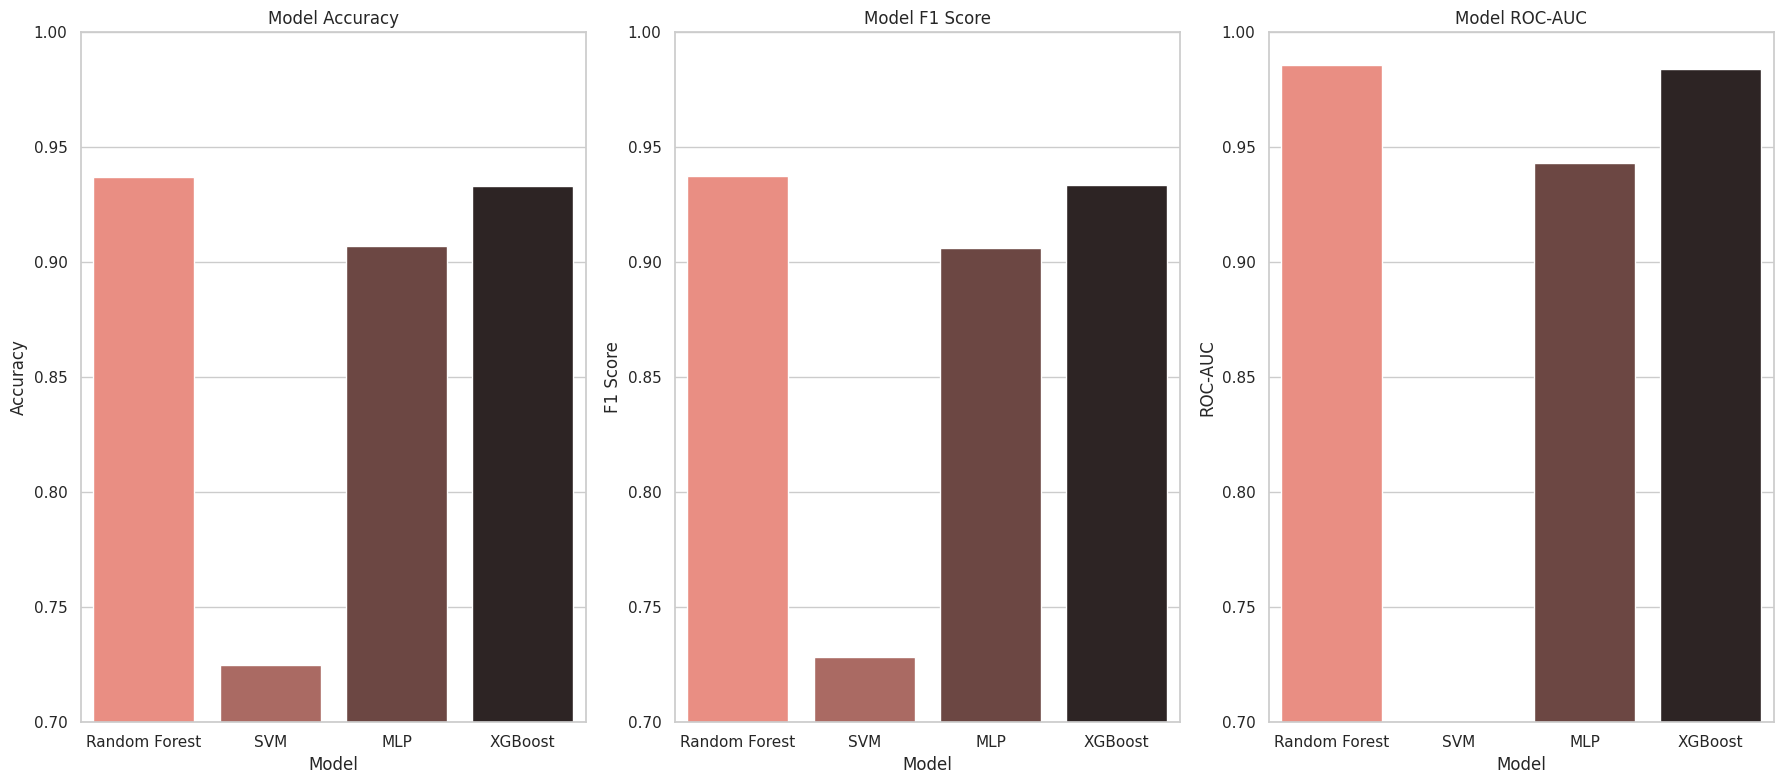

In [41]:
# accuracy, f1, and roc-auc
plt.figure(figsize=(18, 8))
sns.set(style="whitegrid")
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Accuracy', data=df_metrics, palette='dark:salmon_r')
plt.title('Model Accuracy')
plt.ylim(0.7, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')

plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='F1 Score', data=df_metrics, palette='dark:salmon_r')
plt.title('Model F1 Score')
plt.ylim(0.7, 1)
plt.ylabel('F1 Score')
plt.xlabel('Model')

plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='ROC-AUC', data=df_metrics, palette='dark:salmon_r')
plt.title('Model ROC-AUC')
plt.ylim(0.7, 1)
plt.ylabel('ROC-AUC')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

#### Feature importance from RF since it had the best performance

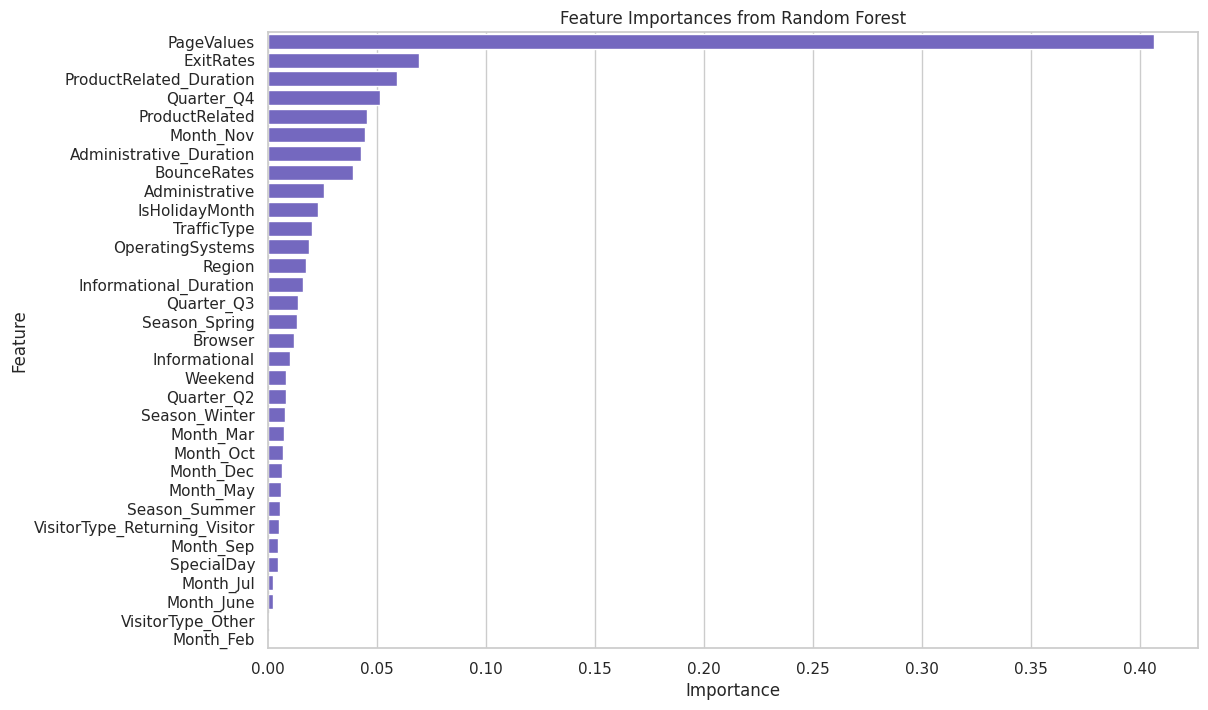

In [42]:
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='slateblue')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Outliers

In [43]:
# Print original dataframe shape
print('Shape:', df.shape)
print(numerical_cols)

# Use IQR to remove outliers
for col in numerical_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  keep = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)
  df_out = df.loc[keep]

# Print new dataframe shape to compare with original
print('New shape:', df_out.shape)
print('Revenue count:', df_out['Revenue'].value_counts())

Shape: (12330, 38)
['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
New shape: (11079, 38)
Revenue count: Revenue
0    9248
1    1831
Name: count, dtype: int64


In [44]:
# Check for data imbalance
print('Counts:', df_out['Revenue'].value_counts())


Counts: Revenue
0    9248
1    1831
Name: count, dtype: int64


In [45]:
# Separate features and target
X = df_out.drop(columns=['Revenue'])
y = df_out['Revenue']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verify the new class distribution
print(y_resampled.value_counts())

# Concatenate the resampled the data
df_resampled = pd.concat([X_resampled, y_resampled.rename('Revenue')], axis=1)

Revenue
0    9248
1    9248
Name: count, dtype: int64


In [46]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (12947, 37), (12947,)
Testing set: (5549, 37), (5549,)


In [47]:
# Scaling data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)

# Concatenate scaled data into one data frame
df_scaled = pd.concat([X_scaled, y_resampled])

# Split scaled data into training and test sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=42)

In [48]:
# Random Forest
print("Random Forest:")
rf_model = RandomForestClassifier(random_state=42)
rf_accuracy, rf_f1 = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

Random Forest:
Accuracy: 0.9310
F1 Score: 0.9318
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2772
           1       0.92      0.94      0.93      2777

    accuracy                           0.93      5549
   macro avg       0.93      0.93      0.93      5549
weighted avg       0.93      0.93      0.93      5549

Confusion Matrix:
[[2551  221]
 [ 162 2615]]


In [49]:
# Support Vector Machine
print("\nSupport Vector Machine:")
svm_model = SVC(random_state=42)
svm_accuracy, svm_f1 = evaluate_model(svm_model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


Support Vector Machine:
Accuracy: 0.9034
F1 Score: 0.8998
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2772
           1       0.94      0.87      0.90      2777

    accuracy                           0.90      5549
   macro avg       0.91      0.90      0.90      5549
weighted avg       0.91      0.90      0.90      5549

Confusion Matrix:
[[2607  165]
 [ 371 2406]]


In [50]:
# Multi Layer Perceptron
print("\nMulti-Layer Perceptron:")
mlp_model = MLPClassifier(random_state=42)
mlp_accuracy, mlp_f1 = evaluate_model(mlp_model, X_train, y_train, X_test, y_test)


Multi-Layer Perceptron:
Accuracy: 0.7032
F1 Score: 0.5879
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.98      0.77      2772
           1       0.96      0.42      0.59      2777

    accuracy                           0.70      5549
   macro avg       0.80      0.70      0.68      5549
weighted avg       0.80      0.70      0.68      5549

Confusion Matrix:
[[2727   45]
 [1602 1175]]


In [51]:
# XGBoost
print("\nXGBoost:")
xgb_model = XGBClassifier(random_state=42)
xgb_accuracy, xgb_f1 = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)


XGBoost:
Accuracy: 0.9315
F1 Score: 0.9316
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2772
           1       0.93      0.93      0.93      2777

    accuracy                           0.93      5549
   macro avg       0.93      0.93      0.93      5549
weighted avg       0.93      0.93      0.93      5549

Confusion Matrix:
[[2583  189]
 [ 191 2586]]


In [52]:
# K-Nearest Neighbors Algorithm
print('\nK-Nearest Neighbors Algorithm')

# Calculate the optimal number of neighbors based on your training data size
n_neighbors = int(np.sqrt(len(X_train)))

# Run and evaluate KNN model on data
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_accuracy, knn_f1 = evaluate_model(knn_model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)


K-Nearest Neighbors Algorithm
Accuracy: 0.8356
F1 Score: 0.8230
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      2772
           1       0.89      0.76      0.82      2777

    accuracy                           0.84      5549
   macro avg       0.84      0.84      0.83      5549
weighted avg       0.84      0.84      0.83      5549

Confusion Matrix:
[[2517  255]
 [ 657 2120]]


In [53]:
# Decision Tree Algorithm
print('\Decision Tree Algorithm')

# Run and evaluate KNN model on data
dt_model = DecisionTreeClassifier()
dt_accuracy, dt_f1 = evaluate_model(dt_model, X_train, y_train, X_test, y_test)

\Decision Tree Algorithm
Accuracy: 0.8991
F1 Score: 0.8996
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2772
           1       0.90      0.90      0.90      2777

    accuracy                           0.90      5549
   macro avg       0.90      0.90      0.90      5549
weighted avg       0.90      0.90      0.90      5549

Confusion Matrix:
[[2481  291]
 [ 269 2508]]


## SVM Model Test

In [54]:
drop = ['IsHolidayMonth', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Bounce_Exit_Rate',
       'Product_Views_Per_Duration', 'Total_Time_Spent', 'Engagement_Intensity']
X_train_final = X_train_scaled.drop(columns=drop)
X_test_final = X_test_scaled.drop(columns=drop)

In [55]:
#Set parameter distribution for random search for Support Vector Machine
svm_param = {
      'C': np.logspace(-3, 3, 7),
      'gamma': np.logspace(-3, 3, 7)
      }

#Create random search object and train on data to find best parameters for decision tree
random_search_svm = RandomizedSearchCV(svm_model, svm_param, cv=5, scoring='accuracy', n_iter=25, random_state=42)
random_search_svm.fit(X_train_final, y_train_scaled)
best_params_svm = random_search_svm.best_params_
print(best_params_svm)
best_svm = random_search_svm.best_estimator_ # Capture the best model

{'gamma': 0.1, 'C': 10.0}


In [56]:
svm_accuracy, svm_f1 = evaluate_model(best_svm, X_train_final, y_train_scaled, X_test_final, y_test_scaled)

Accuracy: 0.8940
F1 Score: 0.8921
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      2772
           1       0.91      0.88      0.89      2777

    accuracy                           0.89      5549
   macro avg       0.89      0.89      0.89      5549
weighted avg       0.89      0.89      0.89      5549

Confusion Matrix:
[[2530  242]
 [ 346 2431]]
